The CRISP-DM system was used in this exercise

1. Business Understanding - The objective of the exercise is to predict income of a citizen (below or above $50k) depending on factors presented.
2. Data Understanding - The data provided is in a csv file containing 32561 records from a census. There are unknown values in columns such as occupation and workclass. Exploratory analysis will be carried out in the notebook below
3. Data Preparation - Unknown records were handled by labelling as 'unknown' and assigned a numerical value.
4. Modelling - 5 models will be evaluated for this classification task: logictic regression, random forest, k-nearest neighbors, decision tree and multi layer perceptron. Training and test data was split 60:40.
5. Evaluation - Each of the 5 models were evaluated with random forest yielding the best results. Feature selection was deployed using recursive feature algorithm (RFE). This marginally improved results with the random forest model still yielding the best results.
6. Deployment - This was not within the scope of this exercise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dt
from pandas_profiling import ProfileReport as pf

In [3]:
census_data = pd.read_csv('censusdb.csv')

In [4]:
census_data.head()

age workclass  fnlwgt     education  education-num marital-status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship     sex  capital-gain  capital-loss  \
0                  ?  Not-in-family  Female             0          4356   
1    Exec-managerial  Not-in-family  Female             0          4356   
2                  ?      Unmarried  Female             0          4356   
3  Machine-op-inspct      Unmarried  Female             0          3900   
4     Prof-specialty      Own-child  Female             0          3900   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              18  United-States  <=50K  
2              40  United-States  <=50K  
3              40  United-States  <=50K  
4              40  United-States  <=50K

In [5]:
census_data.shape

(32561, 14)

In [6]:
census_data.replace('?','Unknown',inplace=True)
census_data.replace('<=50K','0',inplace=True)
census_data.replace('>50K','1',inplace=True)
census_data.head()

age workclass  fnlwgt     education  education-num marital-status  \
0   90   Unknown   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66   Unknown  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship     sex  capital-gain  capital-loss  \
0            Unknown  Not-in-family  Female             0          4356   
1    Exec-managerial  Not-in-family  Female             0          4356   
2            Unknown      Unmarried  Female             0          4356   
3  Machine-op-inspct      Unmarried  Female             0          3900   
4     Prof-specialty      Own-child  Female             0          3900   

   hours-per-week native-country income  
0              40  United-States      0  
1              18  United-States      0  
2              40  United-States      0  
3              40  United-States      0  
4              40  United-States      0

In [7]:
#view column by column analysis using pandas profiling
pf(census_data)

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns

In [9]:
census_data.corr()

age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.076646       0.036527      0.077674      0.057775   
fnlwgt         -0.076646  1.000000      -0.043195      0.000432     -0.010252   
education-num   0.036527 -0.043195       1.000000      0.122630      0.079923   
capital-gain    0.077674  0.000432       0.122630      1.000000     -0.031615   
capital-loss    0.057775 -0.010252       0.079923     -0.031615      1.000000   
hours-per-week  0.068756 -0.018768       0.148123      0.078409      0.054256   

                hours-per-week  
age                   0.068756  
fnlwgt               -0.018768  
education-num         0.148123  
capital-gain          0.078409  
capital-loss          0.054256  
hours-per-week        1.000000

<AxesSubplot:>

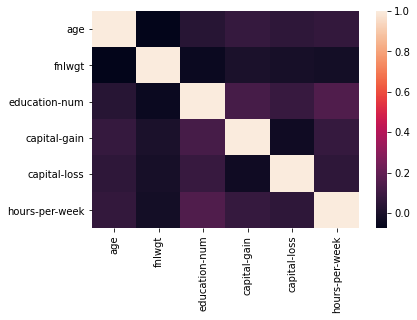

In [10]:
sns.heatmap(census_data.corr())

In [11]:
#handling categorical variables
categorical = ['workclass','occupation','marital-status','education','relationship','sex','native-country']
categories_dummies = pd.get_dummies(census_data[categorical])


In [12]:
census_data = pd.concat([census_data,categories_dummies], axis=1)

In [13]:
census_data = census_data.drop(categorical,axis=1)

In [14]:
census_data

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0       90   77053              9             0          4356              40   
1       82  132870              9             0          4356              18   
2       66  186061             10             0          4356              40   
3       54  140359              4             0          3900              40   
4       41  264663             10             0          3900              40   
...    ...     ...            ...           ...           ...             ...   
32556   22  310152             10             0             0              40   
32557   27  257302             12             0             0              38   
32558   40  154374              9             0             0              40   
32559   58  151910              9             0             0              40   
32560   22  201490              9             0             0              20   

      income  workclass_Federal-gov  workclass_Local-gov  \
0          0                      0                    0   
1          0                      0                    0   
2          0                      0                    0   
3          0                      0                    0   
4          0                      0                    0   
...      ...                    ...                  ...   
32556      0                      0                    0   
32557      0                      0                    0   
32558      1                      0                    0   
32559      0                      0                    0   
32560      0                      0                    0   

       workclass_Never-worked  ...  native-country_Puerto-Rico  \
0                           0  ...                           0   
1                           0  ...                           0   
2                           0  ...                           0   
3                           0  ...                           0   
4                           0  ...                           0   
...                       ...  ...                         ...   
32556                       0  ...                           0   
32557                       0  ...                           0   
32558                       0  ...                           0   
32559                       0  ...                           0   
32560                       0  ...                           0   

       native-country_Scotland  native-country_South  native-country_Taiwan  \
0                            0                     0                      0   
1                            0                     0                      0   
2                            0                     0                      0   
3                            0                     0                      0   
4                            0                     0                      0   
...                        ...                   ...                    ...   
32556                        0                     0                      0   
32557                        0                     0                      0   
32558                        0                     0                      0   
32559                        0                     0                      0   
32560                        0                     0                      0   

       native-country_Thailand  native-country_Trinadad&Tobago  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   
...                        ...                             ...   
32556                        0                               0   
32557                        0             

In [15]:
y = census_data['income']
X = census_data.drop('income',axis=1)

In [16]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.4)

### Preparing the models

In [17]:
LR = LogisticRegression(random_state=1)

In [18]:
KN = KNeighborsClassifier()

In [19]:
DC = DecisionTreeClassifier()

In [20]:
RF = RandomForestClassifier()

In [21]:
MLP = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [22]:
models = [LR,KN,DC,RF]

In [23]:
#create function to train a model and evaluate accuracy
def trainer(model,X_train,y_train,X_valid,y_valid):
    model.fit(X_train,y_train)
    prediction = model.predict(X_valid)
    print('MAE is {}. Accuracy score is {} \n'.format(mean_absolute_error(prediction,y_valid),accuracy_score(prediction,y_valid)))

In [24]:
for model in models:
    print(model)
    trainer(model,X_train,y_train,X_valid,y_valid)
    

LogisticRegression(random_state=1)
MAE is 0.19923224568138195. Accuracy score is 0.800767754318618 

KNeighborsClassifier()
MAE is 0.22142034548944337. Accuracy score is 0.7785796545105567 

DecisionTreeClassifier()
MAE is 0.18955854126679464. Accuracy score is 0.8104414587332054 

RandomForestClassifier()
MAE is 0.14625719769673703. Accuracy score is 0.8537428023032629 



In [25]:
#training multi layer perceptron
MLP.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [26]:
mlp_pred = MLP.predict(X_valid)

In [27]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_valid,mlp_pred))

[[9836   71]
 [2531  587]]


In [28]:
print(classification_report(y_valid,mlp_pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88      9907
           1       0.89      0.19      0.31      3118

    accuracy                           0.80     13025
   macro avg       0.84      0.59      0.60     13025
weighted avg       0.82      0.80      0.75     13025



Random Forest Classifier had best accuracy at 85%

### Feature selection with recursive feature algorithm

In [29]:
# report which features were selected by RFE
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [30]:
#fit RFE
rfe.fit(X, y)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [31]:
for i in range(X.shape[1]):
    print('Column: {}, Selected {}, Rank: {}'.format(i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1
Column: 1, Selected True, Rank: 1
Column: 2, Selected True, Rank: 1
Column: 3, Selected True, Rank: 1
Column: 4, Selected True, Rank: 1
Column: 5, Selected True, Rank: 1
Column: 6, Selected False, Rank: 9
Column: 7, Selected False, Rank: 7
Column: 8, Selected False, Rank: 83
Column: 9, Selected True, Rank: 1
Column: 10, Selected False, Rank: 16
Column: 11, Selected False, Rank: 6
Column: 12, Selected False, Rank: 11
Column: 13, Selected False, Rank: 38
Column: 14, Selected False, Rank: 80
Column: 15, Selected False, Rank: 14
Column: 16, Selected False, Rank: 91
Column: 17, Selected True, Rank: 1
Column: 18, Selected False, Rank: 3
Column: 19, Selected False, Rank: 27
Column: 20, Selected False, Rank: 23
Column: 21, Selected False, Rank: 12
Column: 22, Selected False, Rank: 19
Column: 23, Selected False, Rank: 86
Column: 24, Selected False, Rank: 5
Column: 25, Selected False, Rank: 17
Column: 26, Selected True, Rank: 1
Column: 27, Selected False, Rank: 

In [32]:
X.head()

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   90   77053              9             0          4356              40   
1   82  132870              9             0          4356              18   
2   66  186061             10             0          4356              40   
3   54  140359              4             0          3900              40   
4   41  264663             10             0          3900              40   

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                      0                    0                       0   
1                      0                    0                       0   
2                      0                    0                       0   
3                      0                    0                       0   
4                      0                    0                       0   

   workclass_Private  ...  native-country_Puerto-Rico  \
0                  0  ...                           0   
1                  1  ...                           0   
2                  0  ...                           0   
3                  1  ...                           0   
4                  1  ...                           0   

   native-country_Scotland  native-country_South  native-country_Taiwan  \
0                        0                     0                      0   
1                        0                     0                      0   
2                        0                     0                      0   
3                        0                     0                      0   
4                        0                     0                      0   

   native-country_Thailand  native-country_Trinadad&Tobago  \
0                        0                               0   
1                        0                               0   
2                        0                               0   
3                        0                               0   
4                        0                               0   

   native-country_United-States  native-country_Unknown  \
0                             1                       0   
1                             1                       0   
2                             1                       0   
3                             1                       0   
4                             1                       0   

   native-country_Vietnam  native-country_Yugoslavia  
0                       0                          0  
1                       0                          0  
2                       0                          0  
3                       0                          0  
4                       0                          0  

[5 rows x 103 columns]

In [33]:
X.columns[rfe.get_support()]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Private', 'occupation_Craft-repair',
       'occupation_Sales', 'marital-status_Married-civ-spouse'],
      dtype='object')

In [34]:
#we'll retrain with these new columns
feature_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Private', 'occupation_Craft-repair',
       'occupation_Sales', 'marital-status_Married-civ-spouse']

In [35]:
X_new = X[feature_cols]

In [36]:
X_new_train,X_new_valid,y_new_train,y_new_valid = train_test_split(X,y,test_size=0.4)

In [37]:
#create function to train a model and evaluate accuracy
def trainer_rfe(model,X_train,y_train,X_valid,y_valid):
    model.fit(X_train,y_train)
    prediction = model.predict(X_valid)
    print('MAE is {}. Accuracy score is {} \n'.format(mean_absolute_error(prediction,y_valid),accuracy_score(prediction,y_valid)))

In [38]:
for model in models:
    print(model)
    trainer_rfe(model,X_new_train,y_new_train,X_new_valid,y_new_valid)
    

LogisticRegression(random_state=1)
MAE is 0.20598848368522074. Accuracy score is 0.7940115163147793 

KNeighborsClassifier()
MAE is 0.2274088291746641. Accuracy score is 0.7725911708253359 

DecisionTreeClassifier()
MAE is 0.18272552783109405. Accuracy score is 0.8172744721689059 

RandomForestClassifier()
MAE is 0.14955854126679463. Accuracy score is 0.8504414587332054 



In [39]:
#training multi layer perceptron
MLP.fit(X_new_train,y_new_train)
mlp_pred = MLP.predict(X_new_valid)


In [40]:
print(confusion_matrix(y_new_valid,mlp_pred))

[[9671  192]
 [2524  638]]


In [41]:
print(classification_report(y_new_valid,mlp_pred))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      9863
           1       0.77      0.20      0.32      3162

    accuracy                           0.79     13025
   macro avg       0.78      0.59      0.60     13025
weighted avg       0.79      0.79      0.74     13025



Accuracy marginally improved in general, Random Forest still yielded the best score at 85.45%.
The neural network dropped accuracy very significantly from 0.77 to 0.26

## Implementing Cross Validation

In [42]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)


In [43]:
#create function to train a model and evaluate accuracy
def trainer_with_cv(model,X,y):
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [44]:
for model in models:
    trainer_with_cv(model,X,y)
    

Accuracy: 0.797 (0.008)
Accuracy: 0.775 (0.006)
Accuracy: 0.815 (0.005)
Accuracy: 0.854 (0.008)


Random forest is still the best model with 85.4% accuracy

### Ensemble

In [45]:
#attempting the Bagging Classifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(X_train, y_train)
model.score(X_valid,y_valid)


0.8465259117082533

In [46]:
#attempting the Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(X_train, y_train)
model.score(X_valid,y_valid)

0.8446833013435701

In [48]:
#attempting with XGBoost
import xgboost as xgb
model = xgb.XGBClassifier(learning_rate=0.01,random_state=1)
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

[12:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8609596928982726

In [49]:
#trying out a voting classifier
from sklearn.ensemble import VotingClassifier
#I've previously initialized models earlier in the workbook: LR, KN, DC, RF, MLP
model = VotingClassifier(estimators = [('lr',LR),('kn',KN),('dc',DC),('rf',RF)],voting='hard')
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.8251055662188099

Result of the voting ensemble is worse than for just the random forest classifier

In [50]:
#let's run the voting classifier on the data set with feature selection applied
model.fit(X_new_train,y_new_train)
model.score(X_new_valid,y_new_valid)


0.8204990403071017

In [ ]:
tree.plot_tree(DC)